In [1]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf; print('Tensorflow version:',tf.__version__)
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import sklearn
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import balanced_accuracy_score, accuracy_score

Tensorflow version: 2.8.1


In [2]:
print('Available devices:', tf.config.list_physical_devices())

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1*1024)]
    )

Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
DIRECTORY = 'dataset_plus'
IMAGE_SIZE = (224, 224)
IMAGE_SHAPE = IMAGE_SIZE + (3,)
BATCH_SIZE = 16
COLOR_MODE='rgb'

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
      directory=DIRECTORY
    , image_size=IMAGE_SIZE
    , batch_size=BATCH_SIZE    
    , color_mode=COLOR_MODE
    , validation_split=0.2
    , subset="training"
    , seed=123
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
      directory=DIRECTORY
    , image_size=IMAGE_SIZE
    , batch_size=BATCH_SIZE
    , color_mode=COLOR_MODE
    , validation_split=0.2
    , subset="validation"
    , seed=123
)

Found 11080 files belonging to 8 classes.
Using 8864 files for training.
Found 11080 files belonging to 8 classes.
Using 2216 files for validation.


In [4]:
qtyLabels = [0]*8
Images = {}
for images, labels in train_dataset:
    for image, label in zip(images, labels):
        label = int(label)
        qtyLabels[label] += 1  
        if ( label in Images ):
            if  ( len(Images[label]) < 20 ):
                Images[label].append(image)
        else:
            Images[label] = []
            Images[label].append(image)
class_names = train_dataset.class_names
print(' '.join( ['{:<12}'.format(el) for el in class_names] ))
print(' '.join( ['{:<12}'.format(el) for el in qtyLabels] ))

anger        contempt     disgust      fear         happiness    neutrality   sadness      surprise    
1122         1099         1101         1104         1127         1094         1119         1098        


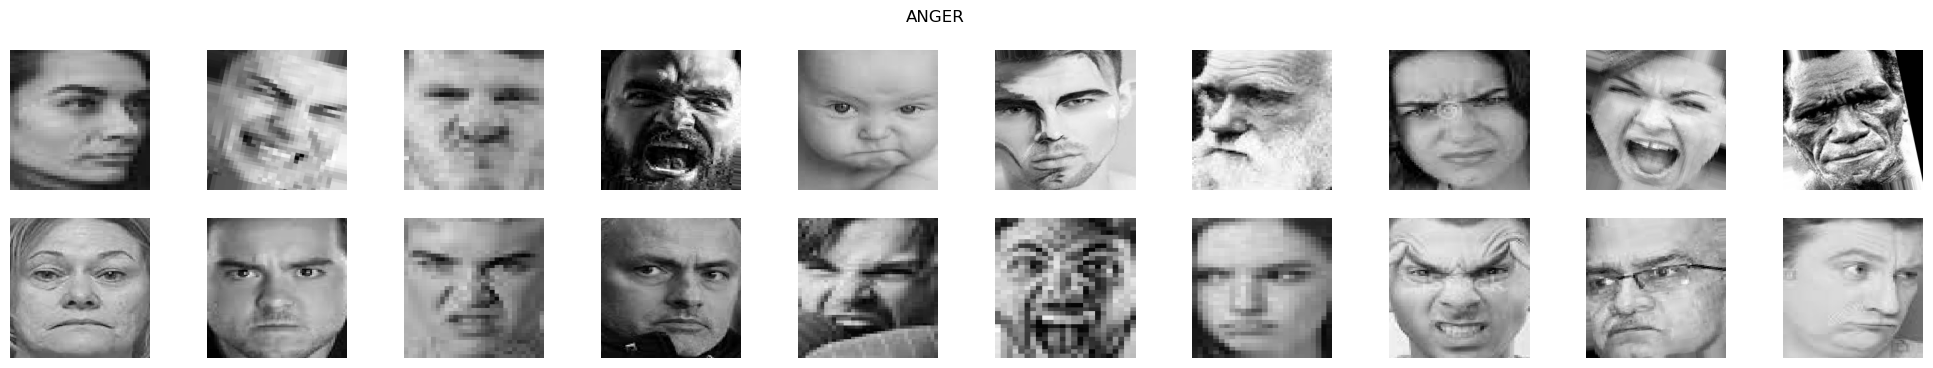

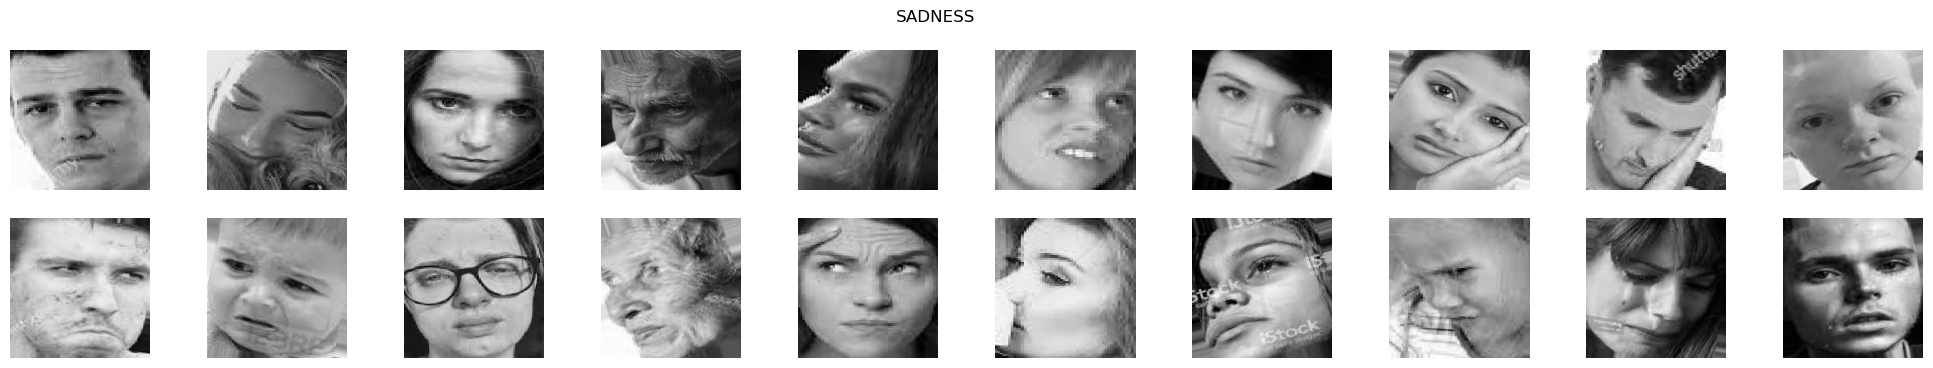

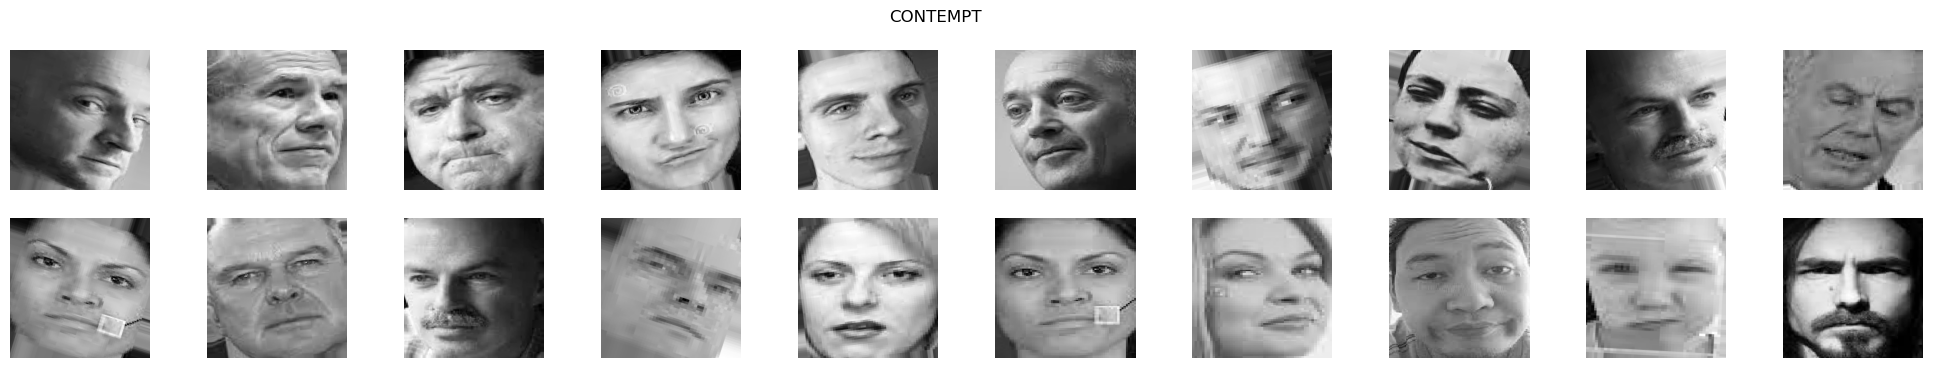

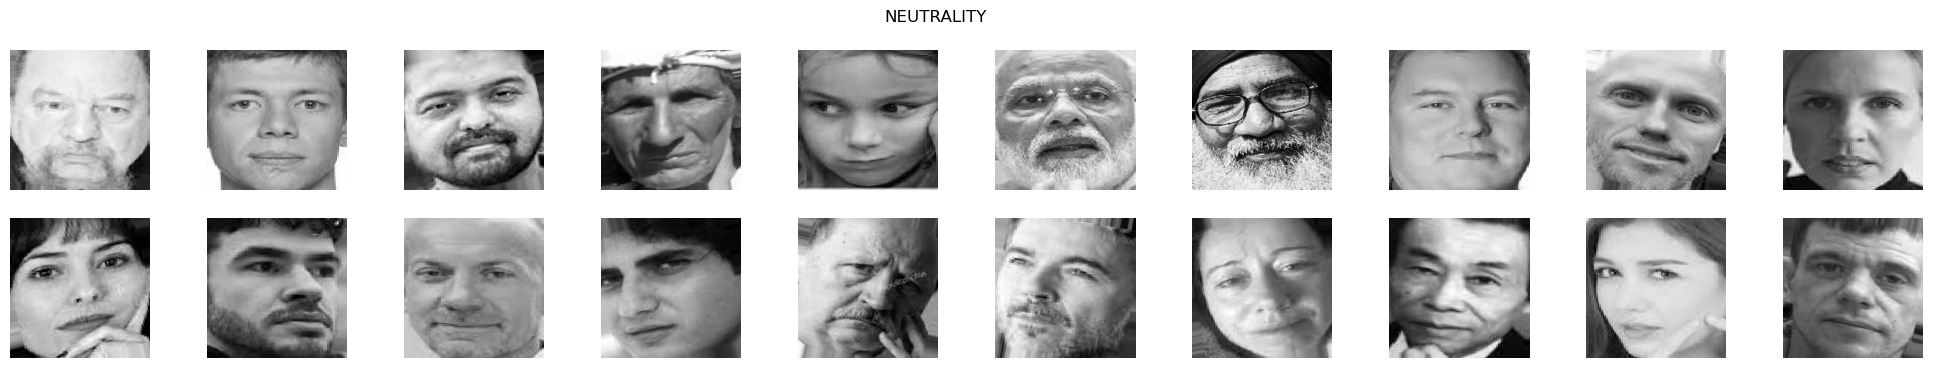

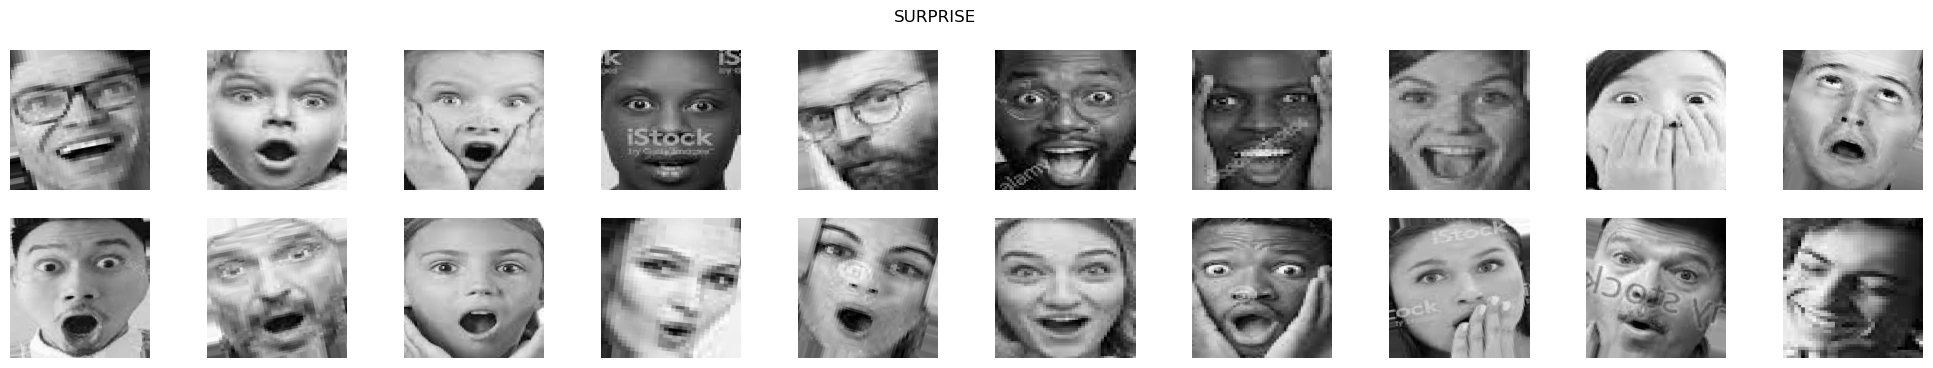

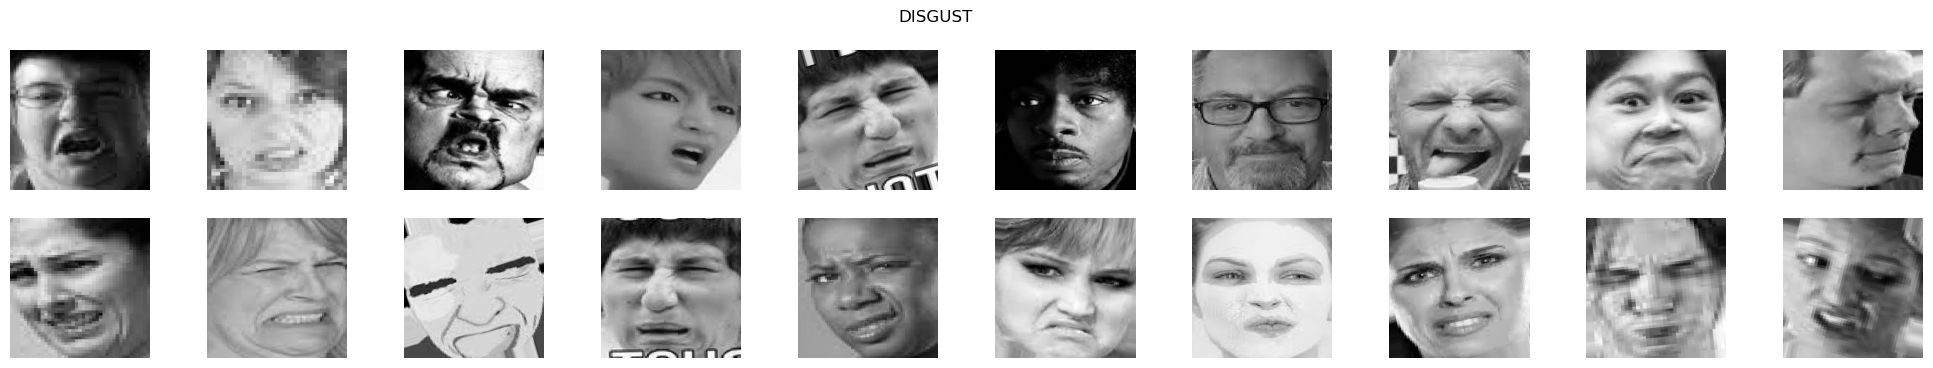

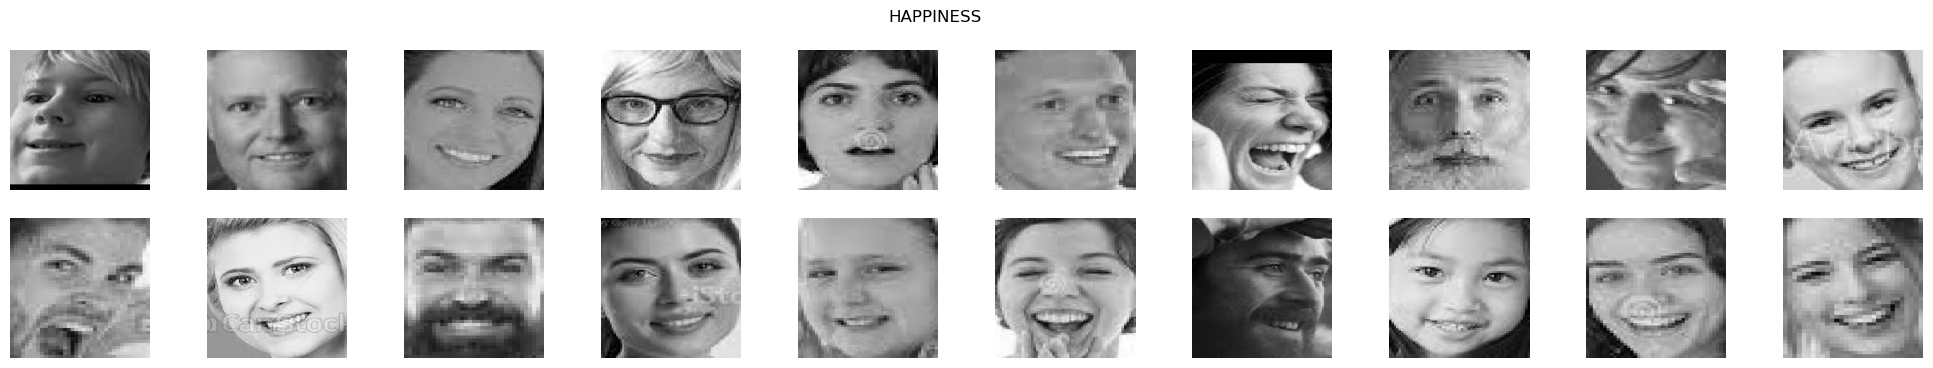

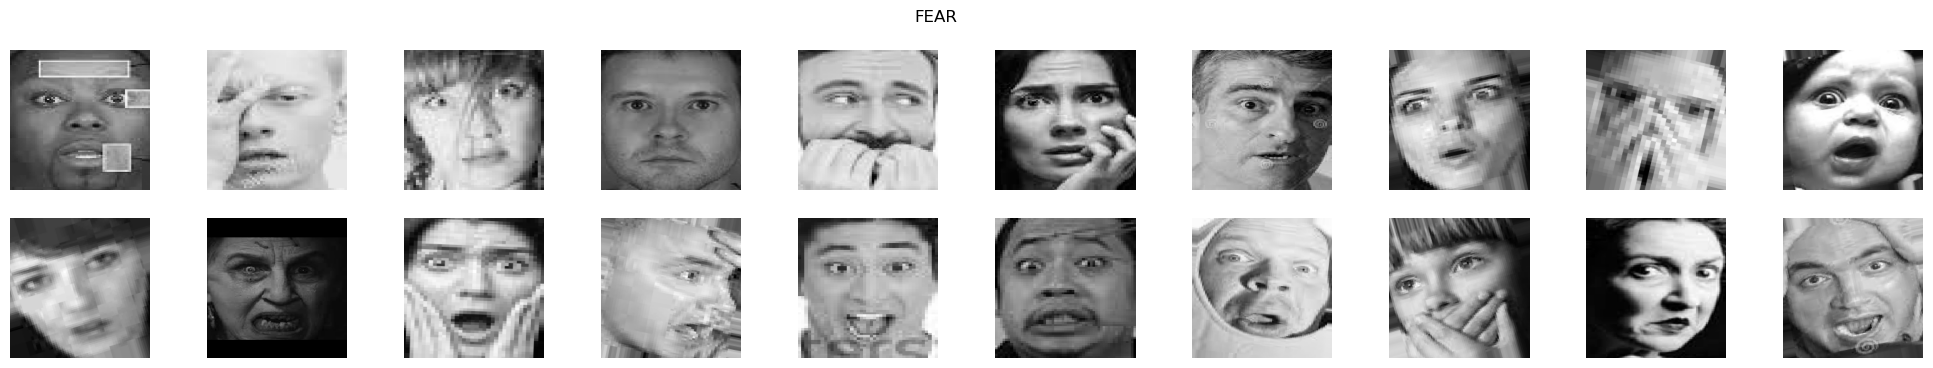

In [5]:
for label in Images:
    images = Images[label]
    class_name = class_names[label]
    f, axs = plt.subplots(2, 10, figsize=(25, 4))
    axs = axs.reshape(-1)
    f.suptitle(class_name.upper())
    for i, image in enumerate(images):
        ax = plt.subplot(2, 10, i + 1)
        axs[i].imshow(image.numpy().astype("uint8"), cmap='gray')
        axs[i].axis("off")    

In [6]:
validation_dataset_cardinality = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(validation_dataset_cardinality // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 139
Number of test batches: 27


In [7]:
# AUTOTUNE = tf.data.AUTOTUNE

train_dataset      = train_dataset.cache().prefetch(buffer_size=BATCH_SIZE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=BATCH_SIZE)
test_dataset       = test_dataset.cache().prefetch(buffer_size=BATCH_SIZE)

# Use data augmentation
ZOOM = (0.0, -0.2)
data_augmentation = tf.keras.Sequential(
    [
          tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal")
        , tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.05, fill_mode='nearest')
        # , tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=ZOOM, width_factor=ZOOM)
    ]
)

2022-11-21 08:19:28.371836: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


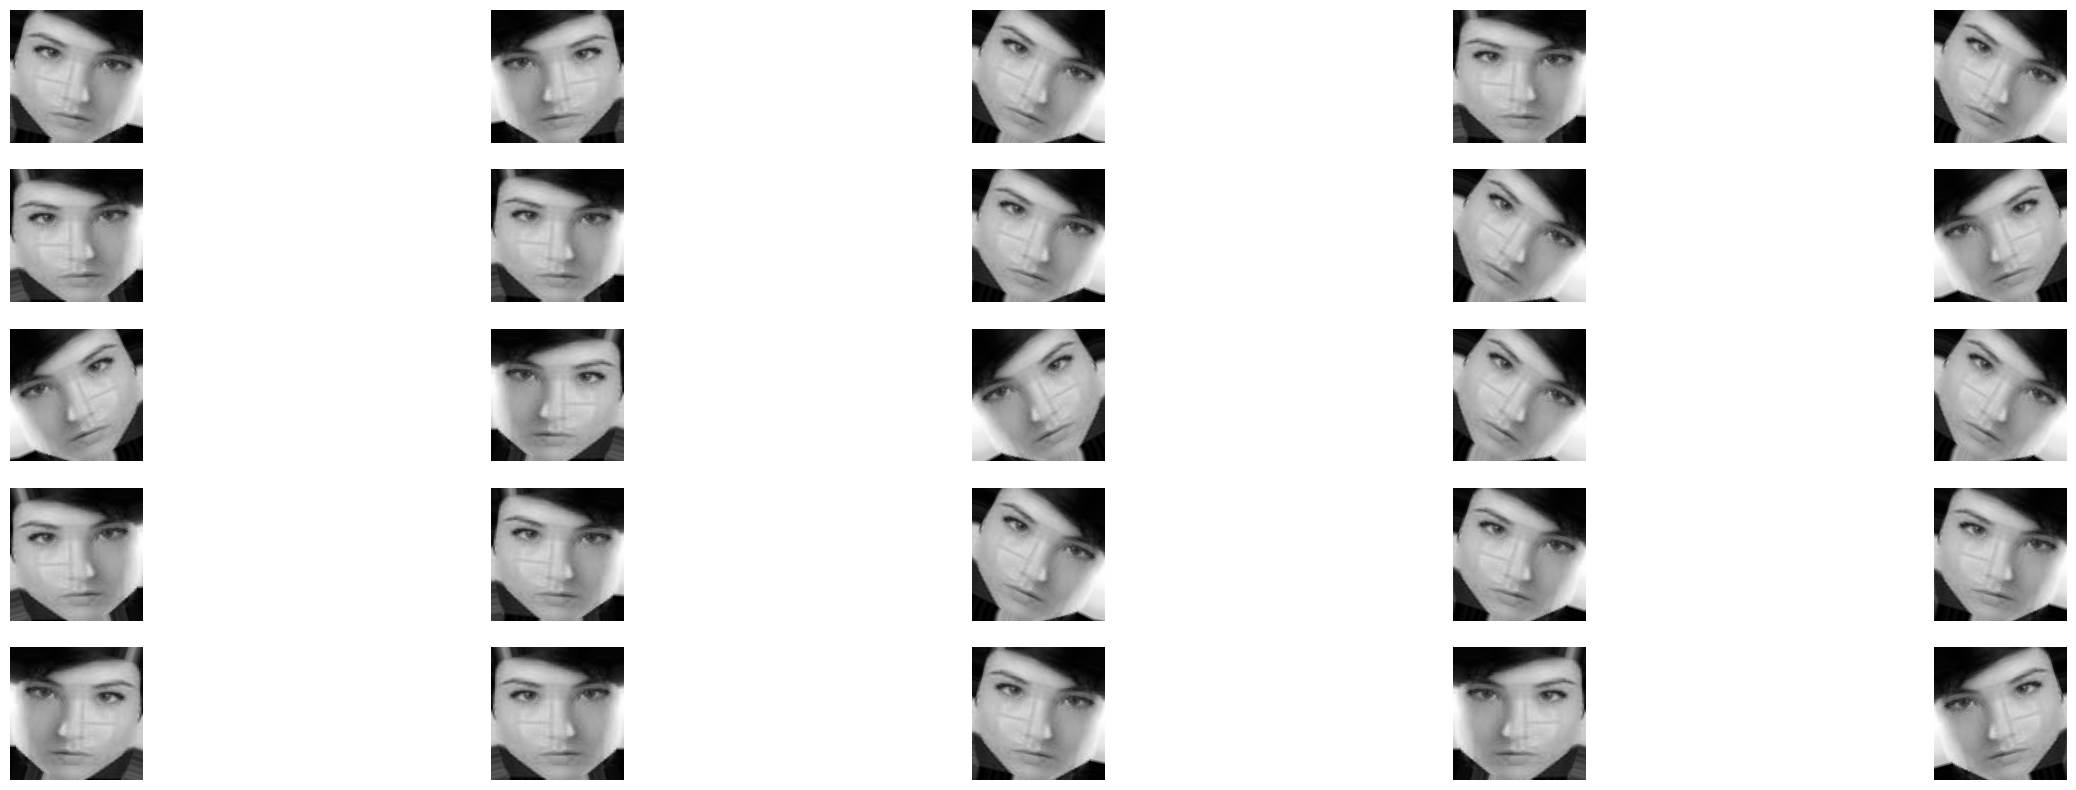

In [8]:
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(30, 10))
    image = images[0]    
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(image, 0))
        plt.imshow(augmented_image[0].numpy() / 255, cmap='gray')
        plt.axis('off')
plt.show()

In [9]:
INPUT_SHAPE = image.shape
# Carregamento do modelo pré-treinado SEM as camadas densas
# (include_top = False)
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)

# Descongela camadas pré-treinadas
for layer in base_model.layers[:-10]:
    layer.trainable = False
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Insere novas camadas no fim da rede para classificação
base_model = tf.keras.Sequential([
base_model,
tf.keras.layers.GlobalAveragePooling2D(),
tf.keras.layers.Dense(8, activation='softmax')
])

base_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 8)                 16392     
                                                                 
Total params: 23,604,104
Trainable params: 4,482,056
Non-trainable params: 19,122,048
_________________________________________________________________


In [10]:
inputs = layers.Input(shape=INPUT_SHAPE)
x = data_augmentation(inputs)
outputs = base_model(x)
model = tf.keras.Model(inputs, outputs)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 8)                 23604104  
                                                                 
Total params: 23,604,104
Trainable params: 4,482,056
Non-trainable params: 19,122,048
_________________________________________________________________


In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = model(image_batch)
print(feature_batch.shape)

2022-11-21 08:19:31.486437: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-11-21 08:19:32.787237: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-11-21 08:19:34.823446: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.14GiB with freed_by_count=0. The caller indicates that this is not a failure

(16, 8)


In [13]:
print('CNN output format')
print(' '.join('{:^12s}'.format(el) for el in class_names))
for row in feature_batch.numpy():
   print(' '.join('{:^12.2f}'.format(el) for el in row))

CNN output format
   anger       contempt     disgust        fear      happiness    neutrality    sadness      surprise  
    0.12         0.06         0.09         0.48         0.15         0.07         0.02         0.02    
    0.29         0.04         0.17         0.17         0.07         0.01         0.05         0.22    
    0.12         0.11         0.10         0.15         0.11         0.01         0.09         0.32    
    0.12         0.20         0.09         0.12         0.03         0.00         0.05         0.40    
    0.28         0.04         0.05         0.11         0.10         0.01         0.20         0.22    
    0.17         0.06         0.07         0.07         0.06         0.00         0.19         0.36    
    0.06         0.07         0.06         0.63         0.04         0.02         0.06         0.07    
    0.22         0.05         0.19         0.11         0.07         0.02         0.05         0.29    
    0.41         0.08         0.08         0.1

In [14]:
print('Dataset label format')
label_batch.numpy()

Dataset label format


array([0, 0, 3, 5, 4, 5, 6, 6, 3, 7, 0, 0, 4, 5, 2, 0], dtype=int32)

In [15]:
METRICS = [
      tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')
]

In [16]:
# Compile the model
base_learning_rate = 0.000001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=METRICS)

In [17]:
# Train the model
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

138/139 [============================>.] - ETA: 0s - loss: 2.7282 - accuracy: 0.1431

2022-11-21 08:20:12.508573: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


139/139 [==============================] - 38s 257ms/step - loss: 2.7267 - accuracy: 0.1435
initial loss: 2.73
initial accuracy: 0.14


In [18]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_freq=10*BATCH_SIZE,
                                                 verbose=1)

initial_epochs = 200
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=initial_epochs,
                    callbacks=[cp_callback]
                    )

Epoch 1/200


2022-11-21 08:20:16.195475: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


  1/554 [..............................] - ETA: 37:26 - loss: 2.1479 - accuracy: 0.1250

2022-11-21 08:20:16.720486: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


159/554 [=======>......................] - ETA: 2:13 - loss: 2.5737 - accuracy: 0.1266
Epoch 1: saving model to training_1/cp.ckpt
319/554 [================>.............] - ETA: 1:22 - loss: 2.5248 - accuracy: 0.1295
Epoch 1: saving model to training_1/cp.ckpt
479/554 [========================>.....] - ETA: 26s - loss: 2.4768 - accuracy: 0.1364
Epoch 1: saving model to training_1/cp.ckpt
554/554 [==============================] - 235s 418ms/step - loss: 2.4512 - accuracy: 0.1388 - val_loss: 2.3351 - val_accuracy: 0.1584
Epoch 2/200
 85/554 [===>..........................] - ETA: 2:37 - loss: 2.2575 - accuracy: 0.1544
Epoch 2: saving model to training_1/cp.ckpt
245/554 [============>.................] - ETA: 1:45 - loss: 2.2748 - accuracy: 0.1541
Epoch 2: saving model to training_1/cp.ckpt
405/554 [====================>.........] - ETA: 50s - loss: 2.2438 - accuracy: 0.1577
Epoch 2: saving model to training_1/cp.ckpt
554/554 [==============================] - 222s 402ms/step - loss: 2.

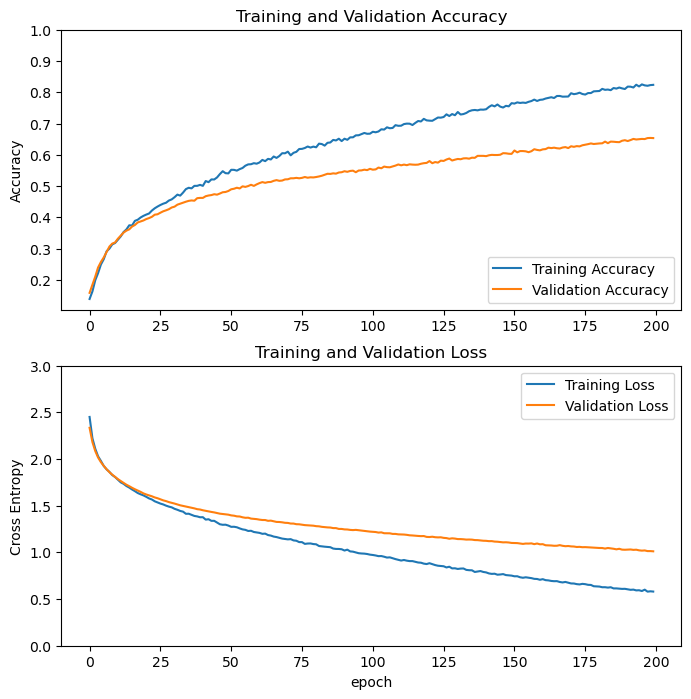

In [19]:
# Show the learning curves of the training and validation accuracy/loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [20]:
Labels = []
Predss = []
count = 0
for batch, labels in validation_dataset:
    logits = model.predict_on_batch(batch)
    preds  = np.argmax(logits, axis=1) 
    Predss += preds.tolist()
    Labels += labels.numpy().tolist()
    count  += 1

In [21]:
print('Confusion matrix')
confusion = confusion_matrix(Labels, Predss)
print(' '.join('{:<12s}'.format(el) for el in class_names))
for row in confusion:
    print(' '.join('{:<12d}'.format(el) for el in row))
print('===')
print('Precision per class')
num = [confusion[i,i] for i in range(len(confusion))]
den = np.sum(confusion, axis=0)
print(' '.join('{:<12s}'.format(el) for el in class_names))
print(' '.join('{:<12.2f}'.format(el) for el in num/den))
print('---')
print('mean precision: {:<12.2f}'.format(np.mean(num/den)))
print('===')
print('Recall per class')
num = [confusion[i,i] for i in range(len(confusion))]
den = np.sum(confusion, axis=1)
print(' '.join('{:<12s}'.format(el) for el in class_names))
print(' '.join('{:<12.2f}'.format(el) for el in num/den))
print('---')
print('mean recall (balanced accuracy score): {:<12.2f}'.format(np.mean(num/den)))

Confusion matrix
anger        contempt     disgust      fear         happiness    neutrality   sadness      surprise    
144          4            14           15           34           8            30           14          
16           212          3            7            27           7            10           4           
52           3            168          7            29           4            19           2           
15           1            7            171          19           6            9            53          
13           1            3            3            220          2            7            9           
32           3            7            6            36           174          28           5           
37           4            15           6            35           16           138          15          
9            0            2            20           31           1            3            221         
===
Precision per class
anger        contempt  

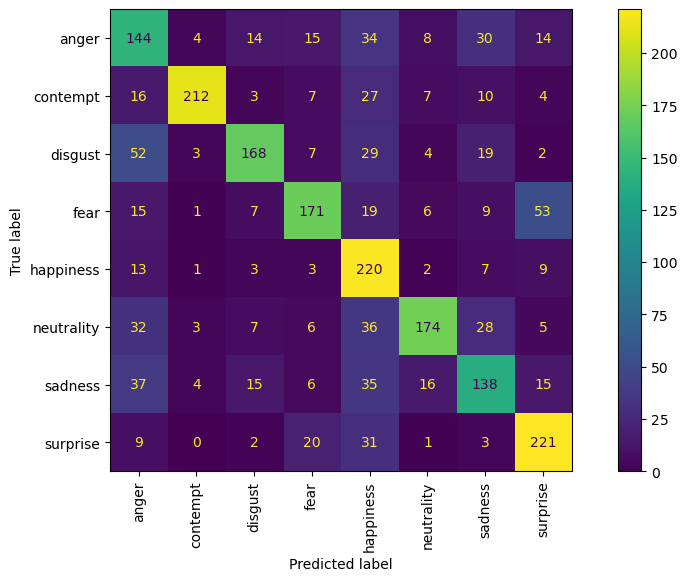

In [22]:
fig, ax = plt.subplots(figsize=(20*0.6, 10*0.6))
ConfusionMatrixDisplay.from_predictions(Labels, Predss, normalize=None, display_labels=class_names, xticks_rotation='vertical', values_format='d', ax=ax)

27/27 [==============================] - 7s 270ms/step - loss: 0.9423 - accuracy: 0.6551
Test accuracy : 0.6550925970077515
pred [[1.08648819e-05 3.49028960e-05 2.17072709e-04 9.95024383e-01
  1.16324075e-03 1.54945155e-04 2.34944117e-03 1.04508724e-03]
 [2.54186273e-01 2.85302009e-03 3.85786481e-02 3.92287318e-03
  6.39657497e-01 4.07047849e-03 5.22010997e-02 4.53012250e-03]
 [2.19221681e-01 2.86679389e-03 7.20955253e-01 2.69179288e-02
  7.07074720e-03 7.13669183e-03 1.43690379e-02 1.46186666e-03]
 [2.65410100e-03 9.72516894e-01 4.13945271e-03 2.78261909e-03
  2.31656682e-04 1.41961416e-02 2.67811585e-03 8.01109942e-04]
 [4.94495690e-01 5.41950203e-03 1.96234137e-01 2.30735376e-01
  1.14075905e-02 7.52565451e-03 2.07457803e-02 3.34363542e-02]
 [2.21499532e-01 4.64505069e-02 3.24086193e-03 1.80358682e-02
  6.89177494e-03 3.55819762e-01 3.27621818e-01 2.04398651e-02]
 [4.81206365e-03 1.24505500e-03 4.54799534e-04 6.17460581e-04
  3.67966332e-02 3.59108642e-04 9.55557287e-01 1.57611765e-

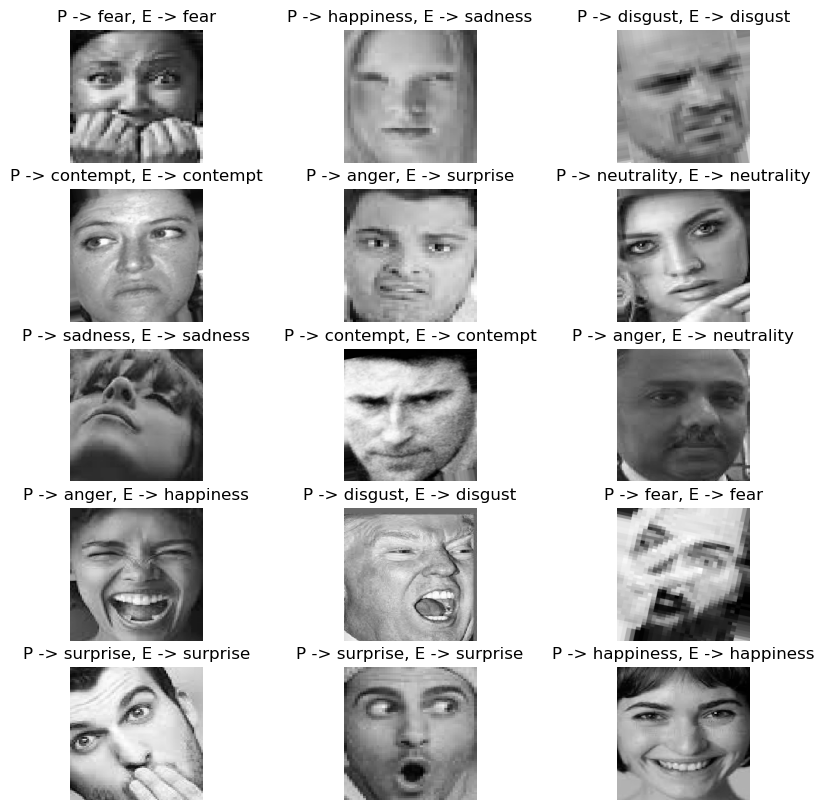

In [23]:
# Evaluation and prediction
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
print('pred', predictions)


# Apply a sigmoid since our model returns logits
predicted_class = np.argmax(predictions, axis=-1)

print('Predictions:\n', predicted_class)
print('Labels:\n', label_batch)
print('Classes:\n', class_names)
plt.figure(figsize=(10, 10))
for i in range(15):
    ax = plt.subplot(5, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"), cmap='gray')
    plt.title('P -> {}, E -> {}'.format(class_names[predicted_class[i]], class_names[label_batch[i]]))
    plt.axis("off")